In [1]:
#from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
import torch
import torch.nn.functional as F
import torch.distributions as distributions
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [3]:
for i in range(len(train_data.data)):
    if (i % 2 == 0):
        train_data.data[i] = torch.randn(*train_data.data[i].shape)
        train_data.targets[i] = np.random.uniform(1,10)

In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f92b9503e80>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f92b9503ac0>}

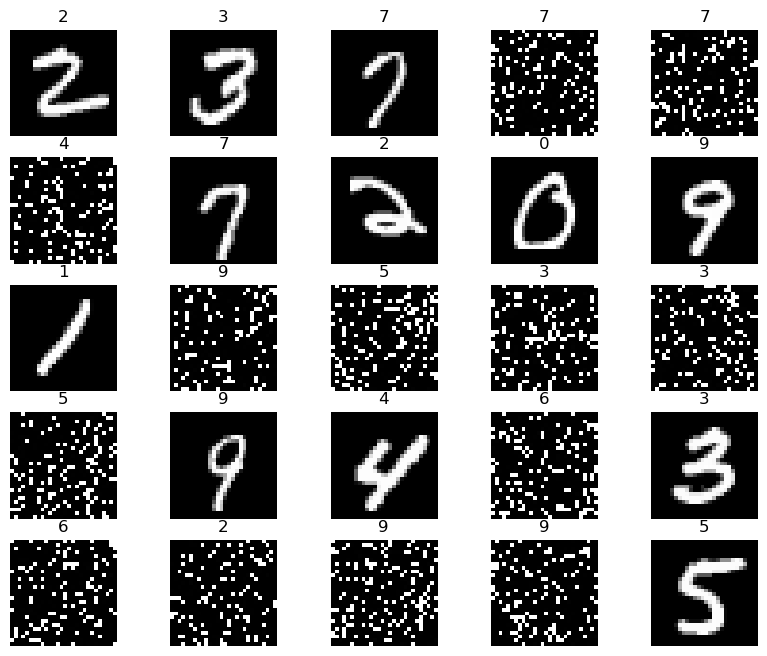

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
        

In [7]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [8]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [9]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [10]:
class Policy(torch.nn.Module):
    def __init__(self):#, state_size, action_size, hidden_dims):#, dropout = 0.5):
        super(Policy, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(32 * 7 * 7, 2)
        
        #self.fc1 = nn.Linear(state_size, hidden_dims)
        #self.fc2 = nn.Linear(hidden_dims, action_size)
        #self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        
        #x = self.fc1(x)
        #x = self.dropout(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return output
    
    def get_action(self, observations):
        state = torch.FloatTensor(observations).unsqueeze(0)
        action_pred = self.forward(state)
        action_prob = F.softmax(action_pred)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
        

In [11]:
policy_net = Policy()
print(policy_net)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.0001)

Policy(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=2, bias=True)
)


In [12]:
# #from https://notebook.community/Diyago/Machine-Learning-scripts/DEEP%20LEARNING/Pytorch%20from%20scratch/TODO/Autoencoders/denoising-autoencoder/Denoising_Autoencoder_Solution
# num_epochs = 10
# noise_factor = 1
# def train(num_epochs, cnn, pg, loaders):
#     gamma = 0.99
#     cnn.train()
        
#     # Train the model
#     total_step = len(loaders['train'])
    
#     for epoch in range(num_epochs):
        
#         for i, (images, labels) in enumerate(loaders['train']):
#             correct = 0
            
#             images_copy = torch.clone(images)
#             labels_copy = torch.clone(labels)
#             # gives batch data, normalize x when iterate train_loader
#             b_x = Variable(images)   # batch x
#             b_y = Variable(labels)   # batch y
#             output = cnn(b_x)[0]
#             loss = loss_func(output, b_y)
            
#             pred_labels = torch.max(output, 1).indices
#             correct += (pred_labels == labels).sum().item()
#             #print(pred_labels)
#             #print(labels)

#             accuracy = correct / len(b_y)
#             #print(accuracy)
            
#             #get agent to look at all images and select
#             rewards = []
#             log_probs = []
#             for j in range(len(b_x)):
#                 correct_2 = 0
#                 keep, log_prob = pg.get_action(b_x[j])
#                 log_probs.append(log_prob)
            
#                 new_batch = []
#                 new_labels = []
#                 if keep == 0:
#                     for k in range(len(b_x)):
#                         new_batch.append(torch.FloatTensor(images[k]))
#                         new_labels.append(labels_copy[k].item())
#                 else:
#                     for k in range(len(b_x)):
#                         if k != j:
#                             new_batch.append(torch.FloatTensor(images[k]))
#                             new_labels.append(labels_copy[k].item())

#                 #print(len(new_batch))
#                 t = torch.stack(new_batch)
#                 l = new_labels.copy()

#                 b_x_2 = Variable(t)
#                 b_y_2 = Variable(torch.Tensor(l))

#                 #get output again based on those images
#                 output_2 = cnn(b_x_2)[0]

#                 #compare the accuracy between those outputs
#                 pred_labels_2 = torch.max(output_2, 1).indices
#                 #print(pred_labels_2)
#                 #print(torch.Tensor(new_labels))
#                 correct_2 += (pred_labels_2 == torch.Tensor(new_labels)).sum().item()

#                 accuracy_2 = correct_2 / len(b_y_2)

#                 rewards.append(100*(accuracy_2 - accuracy))
#                 #print(100*(accuracy_2 - accuracy))
#                 #print(accuracy_2)
                        
#             G = [gamma ** j for j in range(len(rewards) + 1)]
#             discount_rewards = ([a * b for a,b in zip(G, rewards)])

#             policy_loss = 0
#             for j in range(len(log_probs)):
#                 policy_loss += -log_probs[j]*(discount_rewards[j])

#             #training step for PG network
#             policy_optimizer.zero_grad()
#             policy_loss.backward()
#             policy_optimizer.step()
    
#             #get agent to look at all images and select
#             keep_imgs = []
#             for j in range(len(b_x)):
#                 keep, log_prob = pg.get_action(b_x[j])
#                 keep_imgs.append(keep)
#                 log_probs.append(log_prob)
            
#             new_batch_t = []
#             new_labels_t = []
#             for j in range(len(keep_imgs)):
#                 if keep_imgs[j] == 0:
#                     new_batch.append(torch.FloatTensor(images[j]))
#                     new_labels.append(labels_copy[j].item())
                    
#             #print(new_batch)
            

#             if (len(new_batch_t) == 0):
#                 accuracy_2 = 0
#             else:
#                 t = torch.stack(new_batch_t)
#                 l = new_labels_t.copy()

#                 b_x_2 = Variable(t)
#                 b_y_2 = Variable(torch.Tensor(l))

#                 #get output again based on those images
#                 output_2 = cnn(b_x_2)[0]

#                 #compare the accuracy between those outputs
#                 pred_labels_2 = torch.max(output_2, 1).indices
#                 #print(pred_labels_2)
#                 #print(torch.Tensor(new_labels))
#                 correct_2 += (pred_labels_2 == torch.Tensor(new_labels)).sum().item()
                               
#                 accuracy_2 = correct_2 / len(b_y_2)
                
#             # clear gradients for this training step   
#             optimizer.zero_grad()           
            
#             # backpropagation, compute gradients 
#             loss.backward()    
#             # apply gradients             
#             optimizer.step()   
            
            
#             if (i+1) % 100 == 0:
#                 print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Accuracy with Agent: {:.4f}' 
#                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy, accuracy_2))
#                     #pg loss function
                  


            

# train(num_epochs, cnn, policy_net, loaders)

In [ ]:
#from https://notebook.community/Diyago/Machine-Learning-scripts/DEEP%20LEARNING/Pytorch%20from%20scratch/TODO/Autoencoders/denoising-autoencoder/Denoising_Autoencoder_Solution
num_epochs = 10
noise_factor = 1
def train(num_epochs, cnn, pg, loaders):
    gamma = 1
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        rewards = []
        log_probs = []
        
        for i, (images, labels) in enumerate(loaders['train']):
            correct = 0
            correct_2 = 0
            
                
            labels_copy = torch.clone(labels)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            
            pred_labels = torch.max(output, 1).indices
            correct += (pred_labels == labels).sum().item()
            #print(pred_labels)
            #print(labels)

            accuracy = correct / len(b_y)
            #print(accuracy)
            
            #get agent to look at all images and select
            keep_imgs = []
            for j in range(len(b_x)):
                keep, log_prob = pg.get_action(b_x[j])
                keep_imgs.append(keep)
                log_probs.append(log_prob)
                if (j != (len(b_x) -1)):
                    rewards.append(0)
            
            new_batch = []
            new_labels = []
            for j in range(len(keep_imgs)):
                if keep_imgs[j] == 1:
                    new_batch.append(torch.FloatTensor(images[j]))
                    new_labels.append(labels_copy[j].item())
                    
            #print(new_batch)
            

            if (len(new_batch) == 0):
                accuracy_2 = 0
            else:
                t = torch.stack(new_batch)
                l = new_labels.copy()

                b_x_2 = Variable(t)
                b_y_2 = Variable(torch.Tensor(l))

                #get output again based on those images
                output_2 = cnn(b_x_2)[0]

                #compare the accuracy between those outputs
                pred_labels_2 = torch.max(output_2, 1).indices
                #print(pred_labels_2)
                #print(torch.Tensor(new_labels))
                correct_2 += (pred_labels_2 == torch.Tensor(new_labels)).sum().item()
                               
                accuracy_2 = correct_2 / len(b_y_2)
            
            rewards.append(100*(accuracy_2 - accuracy))
                #print(accuracy_2)
                        
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Accuracy with Agent: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy, accuracy_2))
                    #pg loss function
                  
        G = [gamma ** j for j in range(len(rewards) + 1)]
        discount_rewards = ([a * b for a,b in zip(G, rewards)])
        
        policy_loss = 0
        print(len(log_probs))
        print(len(discount_rewards))
        for j in range(len(log_probs)):
            policy_loss += -log_probs[j]*(discount_rewards[j])
        
        print(policy_loss)

        #training step for PG network
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

            

train(num_epochs, cnn, policy_net, loaders)

/var/folders/x4/_sfmqqbj0sq0f3v44_gt4f7h0000gn/T/ipykernel_19327/2893120572.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = F.softmax(action_pred)


Epoch [1/10], Step [100/600], Loss: 1.1813, Accuracy: 0.5500, Accuracy with Agent: 0.6905
Epoch [1/10], Step [200/600], Loss: 1.2888, Accuracy: 0.4900, Accuracy with Agent: 0.5000
Epoch [1/10], Step [300/600], Loss: 1.0559, Accuracy: 0.5700, Accuracy with Agent: 0.6415
Epoch [1/10], Step [400/600], Loss: 1.1198, Accuracy: 0.5100, Accuracy with Agent: 0.5556
Epoch [1/10], Step [500/600], Loss: 1.2803, Accuracy: 0.4900, Accuracy with Agent: 0.4000
Epoch [1/10], Step [600/600], Loss: 1.0965, Accuracy: 0.6200, Accuracy with Agent: 0.6731
60000
60000
tensor([1966.3243], grad_fn=<AddBackward0>)
Epoch [2/10], Step [100/600], Loss: 1.1878, Accuracy: 0.5500, Accuracy with Agent: 0.5581
Epoch [2/10], Step [200/600], Loss: 1.1619, Accuracy: 0.5300, Accuracy with Agent: 0.5294
Epoch [2/10], Step [300/600], Loss: 1.0113, Accuracy: 0.5900, Accuracy with Agent: 0.5897
Epoch [2/10], Step [400/600], Loss: 1.0427, Accuracy: 0.6400, Accuracy with Agent: 0.6304
Epoch [2/10], Step [500/600], Loss: 1.1476, 

In [16]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()

Test Accuracy of the model on the 10000 test images: 0.92
